# Visualização de dados

Uma visualização gráfica dos dados auxilia na identificação de possíveis padrões e na tomada de decisões dos pré-processamentos a serem realizados nos dados. Nem sempre é necessário criar gráficos para todo o *dataset*. Precisamos de gráficos suficientes ter uma ideia do formato geral dos dados (uma amostra).

Antes de plotar os gráficos, é preciso conhecê-los. Estaremos utilizando neste `notebook` um *dataset* com dados EMG coletados de dez voluntários, porém iremos plotar em gráficos apenas os dados de um único voluntário. Neste *dataset* foram coletados 10 movimentos diferentes com dois canais EMG. Iremos plotar um gráfico para cada canal, para cada movimento.

Utilizaremos a biblioteca [matplotlib](https://matplotlib.org) para gerar os gráficos.

In [1]:
# Carregando dados
import numpy as np

data = np.load('./lib/data/converted/s1.npy')
print(f'{data.shape} - (classes, ensaios, canais, linhas)')

(10, 6, 2, 20000) - (classes, ensaios, canais, linhas)


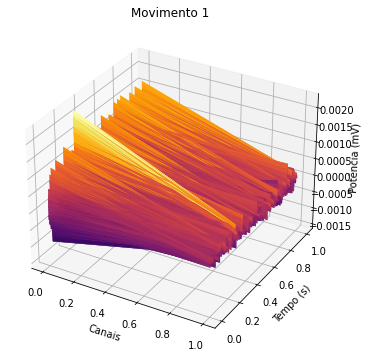

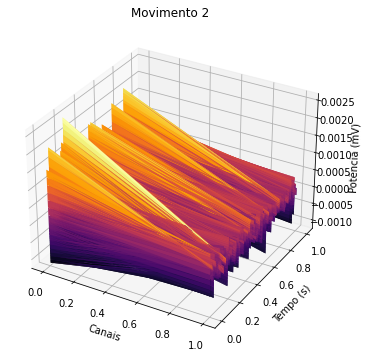

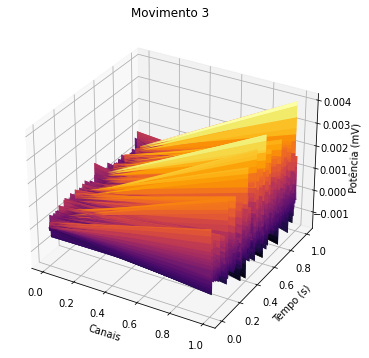

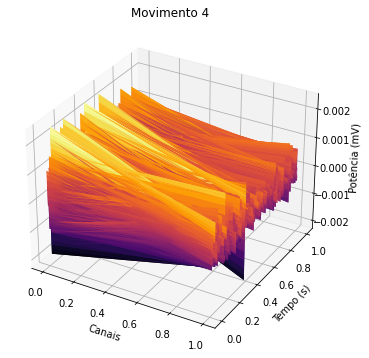

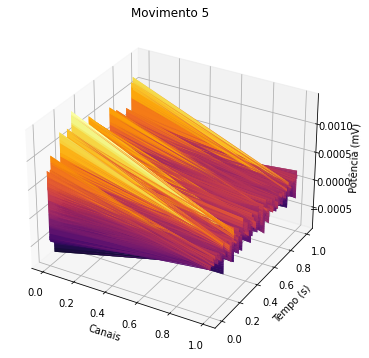

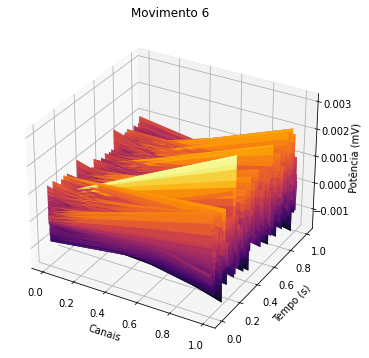

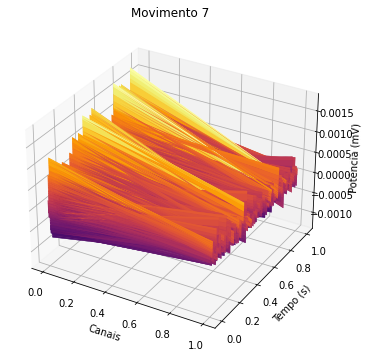

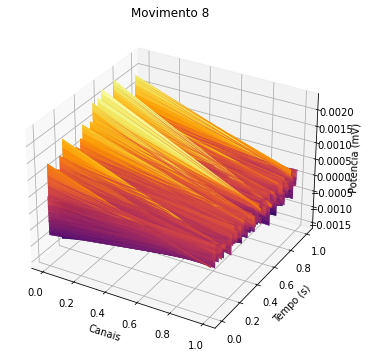

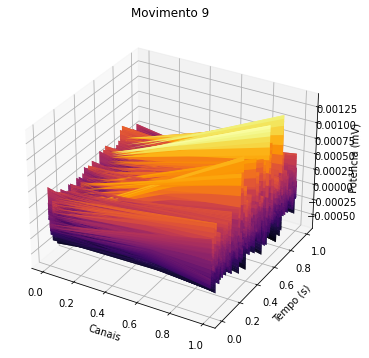

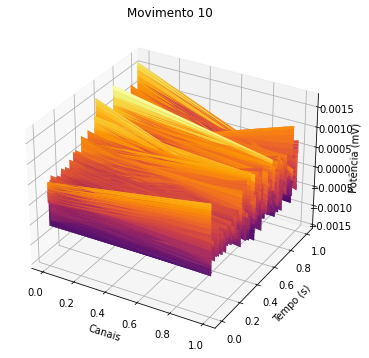

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

rcParams['figure.figsize'] = [18., 6.]

for mov in range(10):
    plot_data = []
    for channel in range(2):
        # espaço de 4000 pontos entre 0 e 1
        for i, t in enumerate(np.linspace(0, 1, 4000)):
            plot_data.append([channel, t, data[mov][0][channel][i]])
    plot_data = np.array(plot_data)
    x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
    ax = plt.axes(projection ='3d')
    ax.set_title('Movimento {}'.format(mov + 1))
    ax.set_xlabel('Canais')
    ax.set_ylabel('Tempo (s)')
    ax.set_zlabel('Potência (mV)')
    ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
    plt.show()

O trecho de código acima, está imprimindo os gráficos dos 10 movimentos apresentados. Porém, é mostrado somente o 1º segundo (primeiros 4.000 pontos equivalentes a 1 segundo) do 1º ensaio.

Isto ocorre, pois se apresentarmos os 5 segundos de experimento, o gráfico terá um peso visual muito maior (20.000 pontos * 2 canais = 40.000 pontos) e demorará muito para mostrar o gráfico dos 10 movimentos.

Como a visualização serve aqui como título de comparação entre os movimentos, não há a necessidade de mostrar todos os pontos. Assim, se faz necessário a apresentação de uma amostra desses pontos.

Todavia, o trecho acima mostra o 1º segundo de cada movimento, o que pode ser ruim, se o movimento possui maior diferenciação um do outro ao longo dos 5 segundos.

Para resolver esse impasse, sugere-se que seja obtido uma amostra dos pontos ao longo dos 5 segundos. Para isso, pode ser utilizanda uma técnica chamada de `resample` (do inglês, reamostragem) do sinal:

(10, 6, 2, 1000)


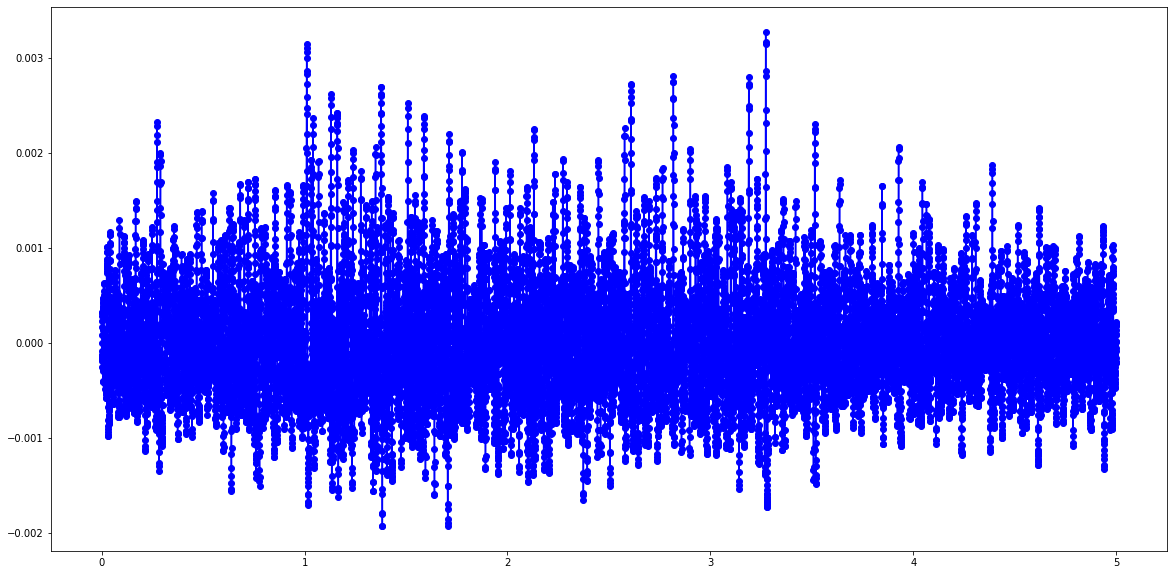

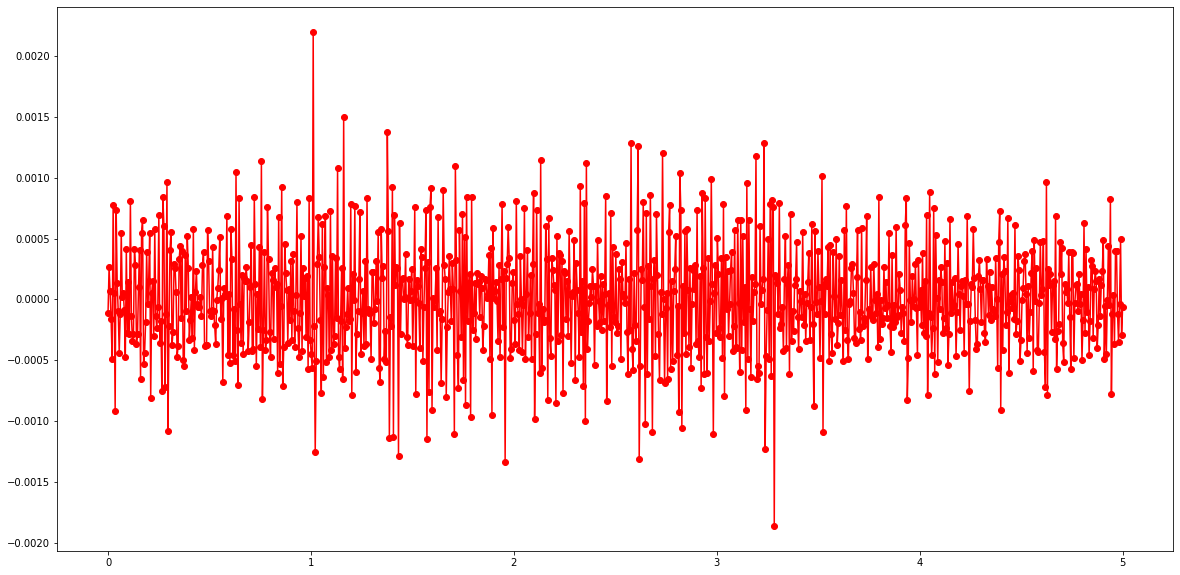

In [3]:
from scipy import signal, fft

# ordem do downsample
do = 20
npts = 20000
rnpts = int(npts / do)

# resample
rdata = signal.resample(data, rnpts, axis=-1)
print(rdata.shape)

rcParams['figure.figsize'] = [20., 10.]

y = data[0,0,0,:]
x = np.linspace(0, 5, npts)

yre = rdata[0,0,0,:]
xre = np.linspace(0, 5, rnpts)

plt.plot(x, y, 'ob-')
plt.show()
plt.plot(xre, yre, 'or-')
plt.show()

**Desafio:** Refazer a comparação dos gráficos dos movimentos e tentar comparar ensaios diferentes lado a lado, de forma a observar semelhanças ou disparidades. Mostre os gráficos normais, os gráficos com `resample`.

É interessante observar o dado também no domínio da frequência, através da transformada de fourier (fft). Utilizando `scipy`, basta chamar `scipy.fft.fft(dado, axis=-1)` para termos a fft. A seguir é implementado os gráficos da fft para os dados normais e para os dados de *resample*.

(10, 6, 2, 20000) - (classes, ensaios, canais, linhas)


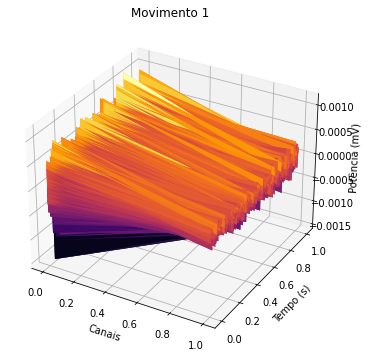

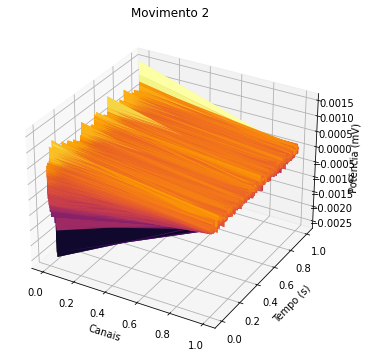

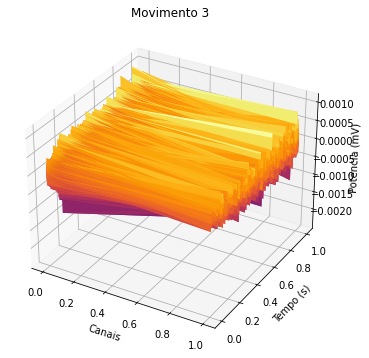

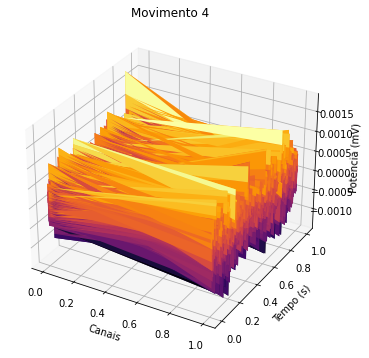

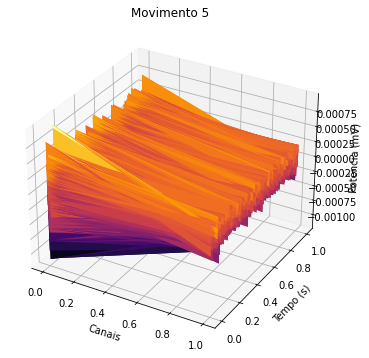

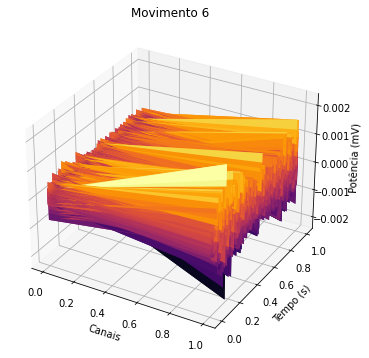

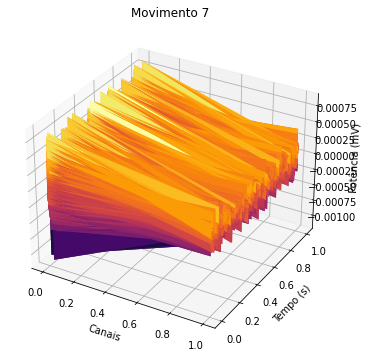

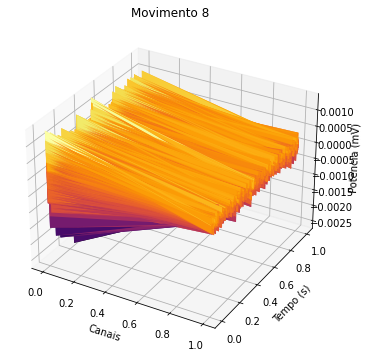

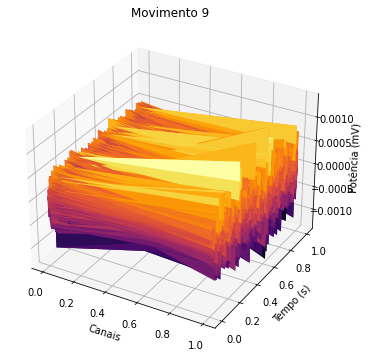

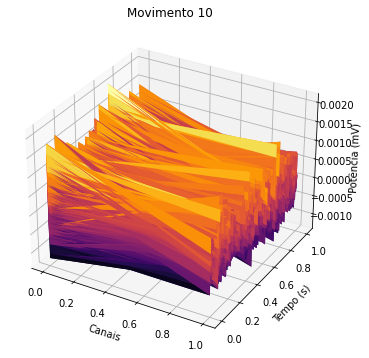

In [33]:
import scipy
import pandas as pd
import numpy as np

def load_csv_save_npy(subject):
    # variável para armazenar os dados das classes
    data = []

    for classe in classes:
        # variável para armazear os dados dos ensaios
        trials = []
        for i in range(1, 7): # de 1 a 6 (Qt. de ensaios)
            # carrega o arquivo .csv para um pandas dataframe
            dataframe = pd.read_csv(f'./lib/data/EMG_2Chs/{subject}/{classe}{i}.csv', delimiter=',', header=None)

            # converte os dados do um ensaio para numpy array e o adiciona na lista de ensaios
            trials.append(dataframe.to_numpy())

        # adiciona os ensaios de uma classe a lista de dados das classes
        data.append(trials)

    # transforma os dados das classes em um numpy array
    data = np.array(data)

    # Salva o numpy array 'data' em './lib/data/converted/{subject}.npy'
    np.save(f'./lib/data/converted/{subject.split("-")[-1]}', data)
    
    
def load_dataset(name):
    from pathlib import Path
    
    all_data = dict()
    fileObj = Path(f'./lib/data/converted/{name}.npy')
        
    if not fileObj.exists():
        load_csv_save_npy(name)
        
    all_data[name.split('-')[-1]] = np.load(f'./lib/data/converted/{name.split("-")[-1]}.npy')
    
    return all_data


def plot_graph(data, classes):

    if data.shape[2] != 2:
        data = np.moveaxis(data, 2, -1)

    print(str(data.shape) + ' - (classes, ensaios, canais, linhas)')
    
    
    rcParams['figure.figsize'] = [18., 6.]
    
    # resample
    rdata = signal.resample(data, 4000, axis=-1)
    # rdata = scipy.fft.fft(data, 4000, axis=-1)
    
    for mov in range(10):
        plot_data = []
        for channel in range(2):
            # espaço de 4000 pontos entre 0 e 1
            for i, t in enumerate(np.linspace(0, 1, 4000)):
                plot_data.append([channel, t, rdata[mov][0][channel][i]])
        plot_data = np.array(plot_data)
        x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
        ax = plt.axes(projection ='3d')
        ax.set_title('Movimento {}'.format(mov + 1))
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (s)')
        ax.set_zlabel('Potência (mV)')
        ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
        plt.show()


classes = ['T-I','T-L','T-M','T-R','T-T','HC-','I-I','L-L','M-M','R-R']
data = load_dataset('EMG-S10')
plot_graph(data['S10'], classes)






**Desafio:** Refazer a comparação dos gráficos dos movimentos e tentar comparar ensaios diferentes lado a lado, de forma a observar semelhanças ou disparidades. Mostre os gráficos de fft para os dados normais e para os dados com `resample`.

O espectograma dos dados do *resample* pode ser obtivo utilizando a função  `specgram` do `matplotlib`, como demonstrado a seguir:

(10, 6, 2, 20000) - (classes, ensaios, canais, linhas)


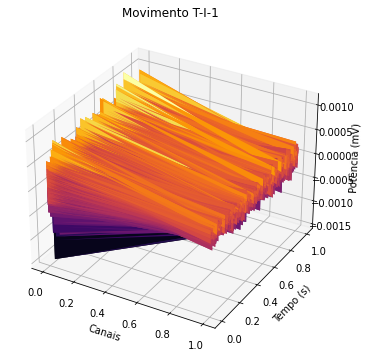

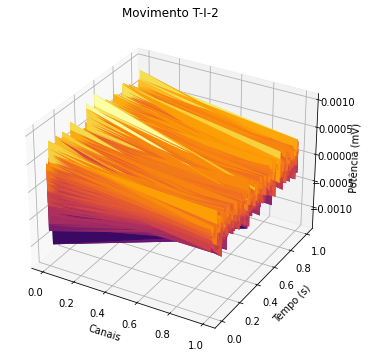

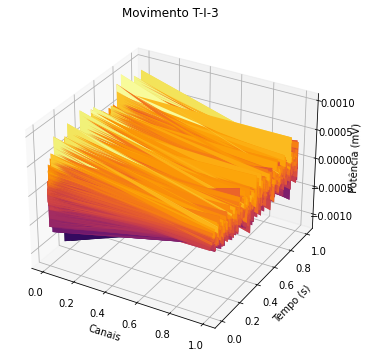

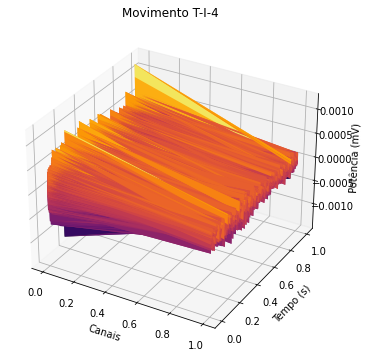

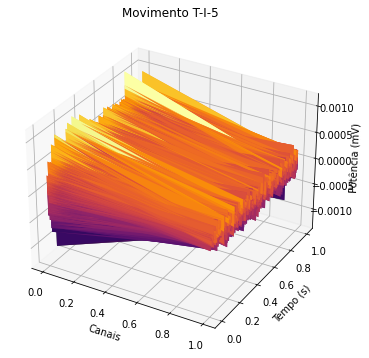

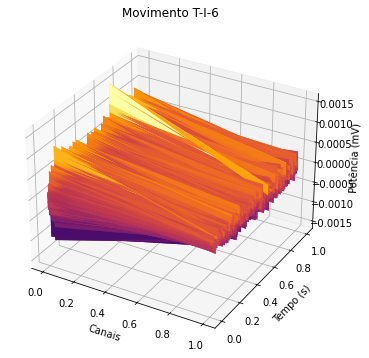

In [48]:
def plot_diferent_trials(data, classe):

    if data.shape[2] != 2:
        data = np.moveaxis(data, 2, -1)

    print(str(data.shape) + ' - (classes, ensaios, canais, linhas)')
    
    classe_index = classes.index(classe)
    
    rcParams['figure.figsize'] = [18., 6.]
    
    # resample
    rdata = signal.resample(data, 4000, axis=-1)
    # rdata = scipy.fft.fft(data, 4000, axis=-1)
    
    for trial in range(len(rdata[classe_index])):
        plot_data = []
        for channel in range(2):
            # espaço de 4000 pontos entre 0 e 1
            for i, t in enumerate(np.linspace(0, 1, 4000)):
                plot_data.append([channel, t, rdata[classe_index][trial][channel][i]])
        plot_data = np.array(plot_data)
        x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
        ax = plt.axes(projection ='3d')
        ax.set_title(f'Movimento {classe}-{trial+1}')
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (s)')
        ax.set_zlabel('Potência (mV)')
        ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
        plt.show()


plot_diferent_trials(data['S10'], 'T-I')

**Desafio:** Refazer a comparação dos gráficos dos movimentos e tentar comparar ensaios diferentes lado a lado, de forma a observar semelhanças ou disparidades. Mostre os gráficos de espectograma para os dados normais e para os dados com `resample`.

(10, 6, 2, 20000) - (classes, ensaios, canais, linhas)
Movimento da classe T-I, ensaio 1
Com todos os pontos


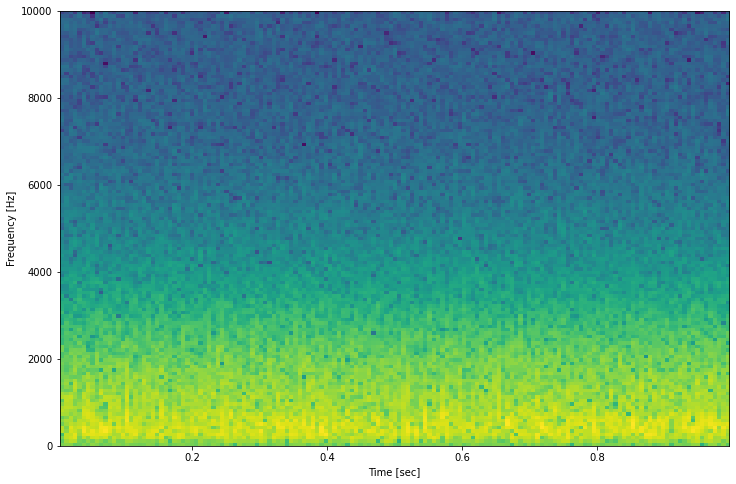

Com resample de 4000 pontos


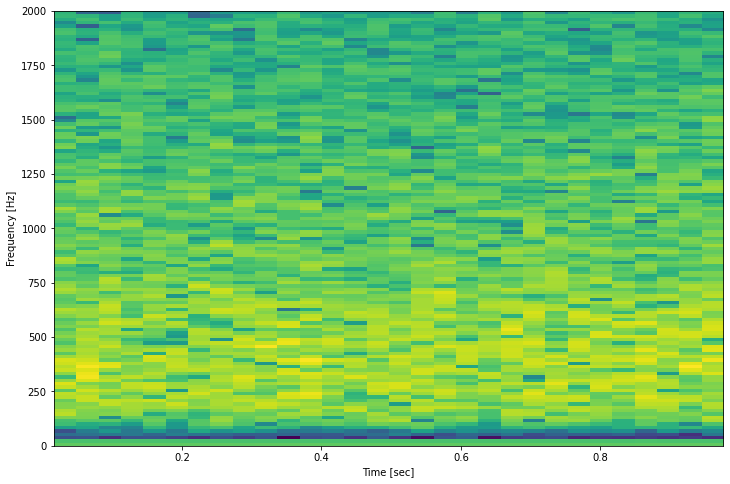

Movimento da classe T-I, ensaio 2
Com todos os pontos


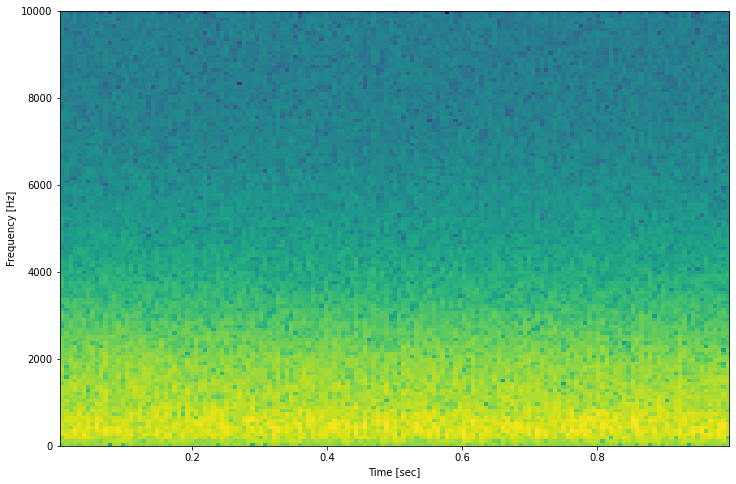

Com resample de 4000 pontos


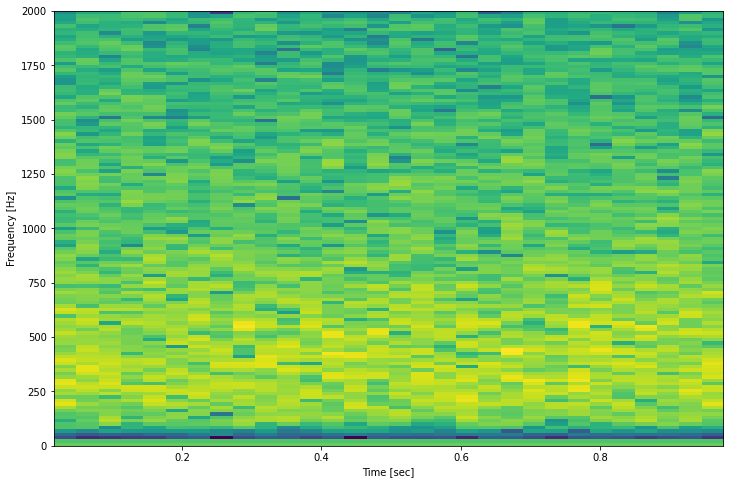

Movimento da classe T-I, ensaio 3
Com todos os pontos


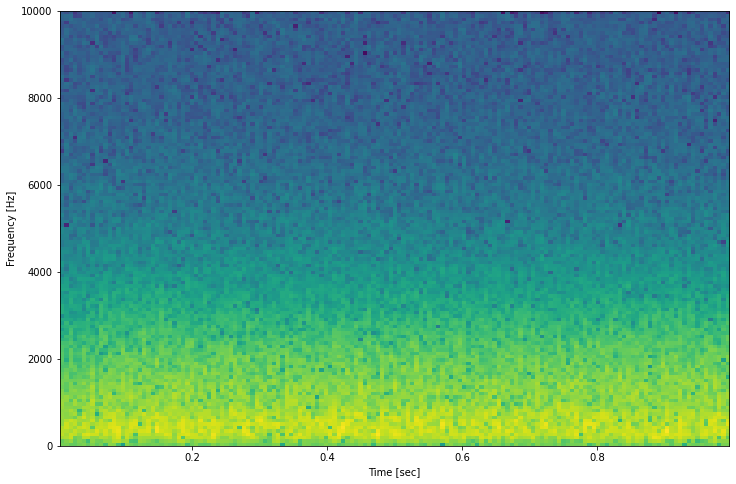

Com resample de 4000 pontos


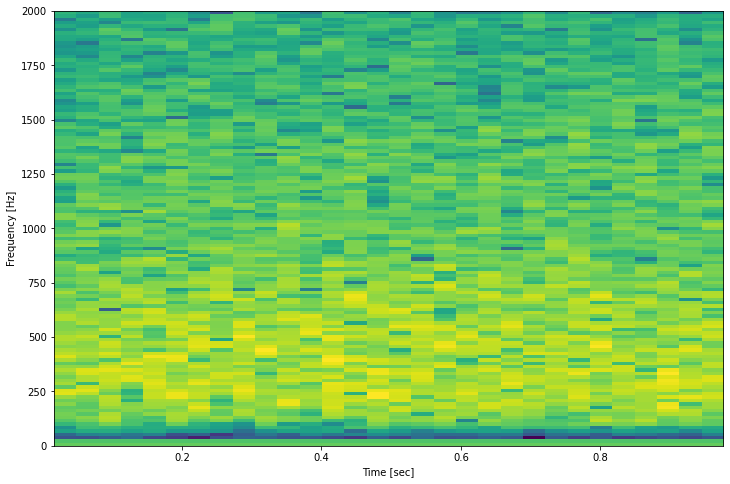

Movimento da classe T-I, ensaio 4
Com todos os pontos


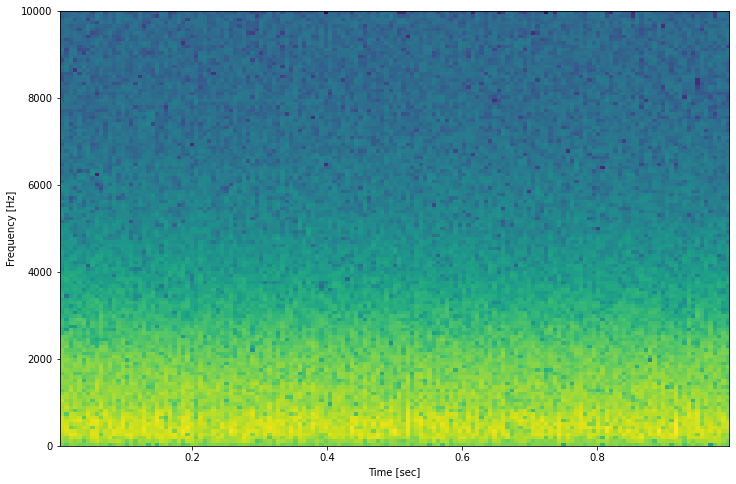

Com resample de 4000 pontos


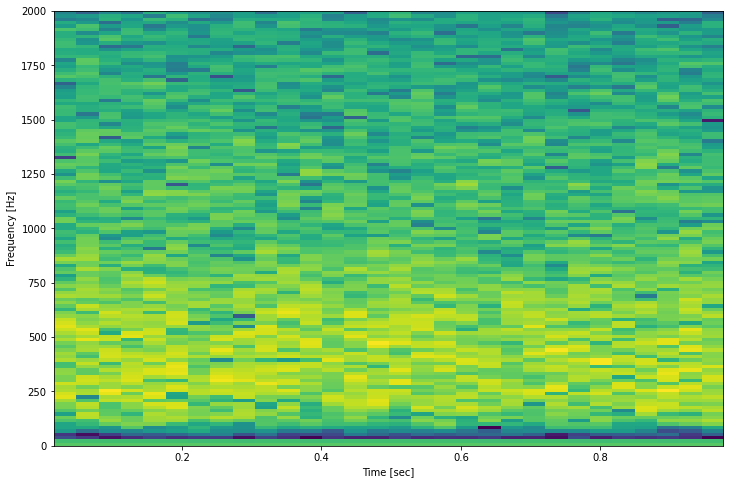

Movimento da classe T-I, ensaio 5
Com todos os pontos


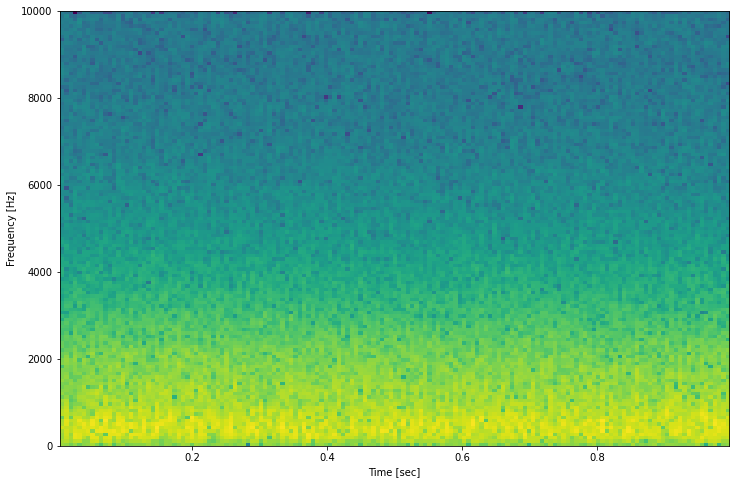

Com resample de 4000 pontos


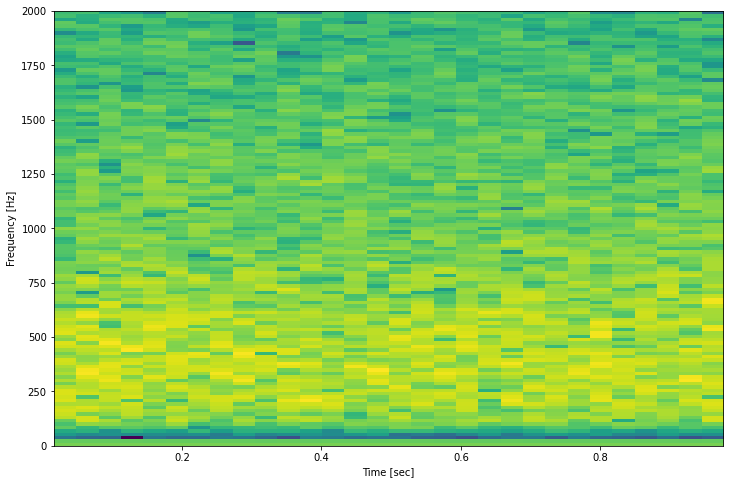

Movimento da classe T-I, ensaio 6
Com todos os pontos


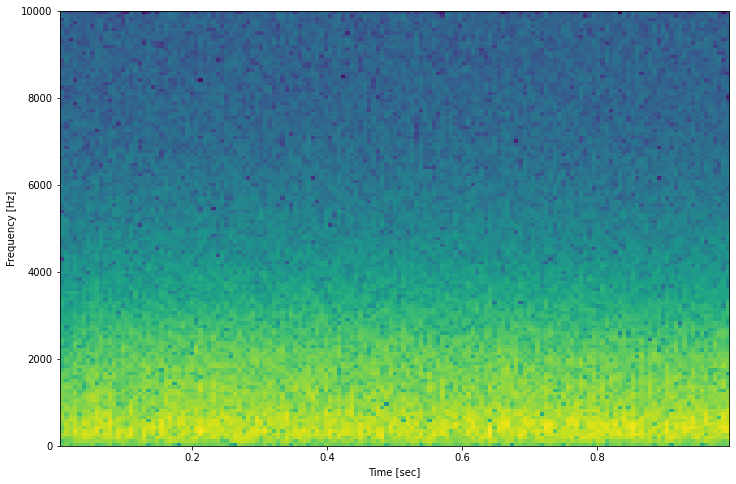

Com resample de 4000 pontos


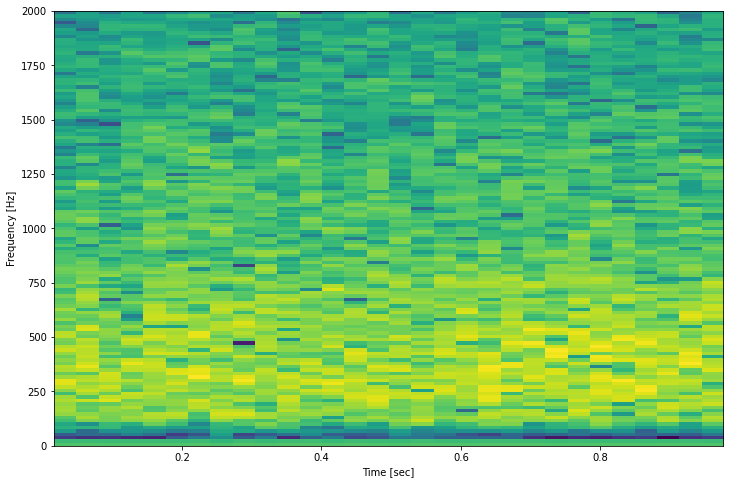

In [59]:
def plot_spectogram_graph(data, classe):

    if data.shape[2] != 2:
        data = np.moveaxis(data, 2, -1)

    print(str(data.shape) + ' - (classes, ensaios, canais, linhas)')
    
    classe_index = classes.index(classe)
    
    # ordem do downsample
    do = 5
    npts = 20000
    rnpts = int(npts / do)

    # resample
    rdata = signal.resample(data, rnpts, axis=-1)
    # rdata = scipy.fft.fft(data, rnpts, axis=-1)

    rcParams['figure.figsize'] = [12., 8.]

    for trial in range(len(data[classe_index])):            
        print(f'Movimento da classe {classe}, ensaio {trial + 1}')

        print('Com todos os pontos')
        plt.specgram(data[classe_index,trial,0,:], Fs=npts)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

        print(f'Com resample de {rnpts} pontos')
        plt.specgram(rdata[classe_index,trial,0,:], Fs=rnpts)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()


plot_spectogram_graph(data['S10'], 'T-I')